In [31]:
import pandas as pd
import spacy
from evaluate import load
import seaborn as sns
import matplotlib.pyplot as plt
# import mauve
import nltk
import numpy as np
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
from nltk import word_tokenize, pos_tag
nlp = spacy.load("en_core_web_sm")

In [167]:
df_generation = pd.read_csv('datasets/Generation_results/df_len2000.csv')
df_generation

,text,length
0,"It can not be read as this story ends, and mus...",46
1,""" Ms Collins said she was told when she woke s...",19
2,As they ’d gone into the thickets of pictures ...,59
3,Ties that have been around for decades have pr...,28
4,"Ultimately, starting the Giants ’ offseason pr...",31
...,...,...
1995,"At another point, he said : “ That sounds like...",24
1996,The US invaded the Hague Convention of Human R...,10
1997,Deep learning approaches have successfully fos...,20
1998,These films will feature 16 - bit cinematograp...,26


In [192]:
df_chatgpt = pd.read_csv('datasets/Generation_results/df_chat_len2.csv')
df_chatgpt

,text,length
0,"The sun sets, painting the sky orange.",7
1,"She smiled, her eyes sparkling.",5
2,The waves crashed against the rocks as seagull...,10
3,The moonlight danced upon the shimmering lake'...,8
4,The autumn leaves whispered secrets in the bre...,7
...,...,...
141,As the morning sun painted the sky in hues of ...,65
142,"In the realm of imagination, where dreams take...",70
143,"In the tapestry of life, we are all interconne...",73
144,"In the vast expanse of the universe, our tiny ...",78


In [3]:
df_train = pd.read_csv('../230503_ucu_materials/data/train.csv')

In [171]:
def preprocess(sentence):
    doc = nlp(sentence)
    string = ''
    for token in doc:
        string += token.text
        string += ' '
    return string[:-1]

In [172]:
df_generation['text'] = df_generation['text'].apply(preprocess)

In [173]:
sns.set(style='darkgrid')

# 1. Control metrics

In [106]:
def part_of_speech(sentence):
  pos = []
  doc = nlp(sentence)
  for token in doc:
    pos.append(token.pos_)
  return pos

In [112]:
def preprocess_sent(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [114]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [115]:
def sentiment_analysis(sentence):
    sentence = preprocess_sent(sentence)
    encoded_input = tokenizer(sentence, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores) 
    return np.argmax(scores)

In [198]:
def tense_detect(sentence):
  text = word_tokenize(sentence)
  tagged = pos_tag(text)
    
  verb_tags = ['MD','MDF',
              'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
              'DO','DOD','DOZ',
              'HV','HVG','HVN','HVD','HVZ',
              'VB','VBG','VBN','VBD','VBZ',
              'SH',
              'TO',
              'JJ' # maybe?
              ]
    
  verb_phrase = []
  for item in tagged:
    if item[1] in verb_tags:
        verb_phrase.append(item)
  if (verb_phrase == []):
    return({'Not detected'})

  grammar = r"""
    future:                    {<MD><VB><VBN><VBG>}
    future:                    {<MD><VB><VBG>}
    future:                    {<MD><VB><VBN>}
    past:                      {<VBD><VBN><VBG>}
    present:                   {<VBP|VBZ><VBN><VBG>}
    future:                    {<MD><VB>}
    past:                      {<VBD><VBG>}
    past:                      {<VBD><VBN>}
    present:                   {<VBZ|VBP><VBG>}
    present:                   {<VBZ|VBP><VBN>}
    past:                      {<VBD>}
    present:                   {<VBZ>|<VBP>}
  """

  cp = nltk.RegexpParser(grammar)
  result = cp.parse(verb_phrase)
#  display(result)    
                      
  tenses_set = set()
  for node in result:
    if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
  
  return tenses_set

In [107]:
df_generation['pos_check'] = df_generation['text'].apply(part_of_speech)
# df_generation['sentiment_check'] = df_generation['text'].apply(sentiment_analysis)
# df_generation['tense_check'] = df_generation['text'].apply(tense_detect)
df_generation

,text,pos,pos_check
0,He loves his adorable dog and ca n't wait to p...,PRON VERB ADJ PRON AUX ADJ PART VERB ADV ADV A...,"[PRON, VERB, PRON, ADJ, NOUN, CCONJ, AUX, PART..."
1,She is excitedly singing along to the beautifu...,PRON VERB ADJ PRON AUX ADJ PART VERB ADV ADV A...,"[PRON, AUX, ADV, VERB, ADP, ADP, DET, ADV, VER..."
2,They were genuinely surprised when the expertl...,PRON VERB ADJ PRON AUX ADJ PART VERB ADV ADV A...,"[PRON, AUX, ADV, ADJ, SCONJ, DET, ADV, ADJ, NO..."
3,I am eagerly looking forward to exploring the ...,PRON VERB ADJ PRON AUX ADJ PART VERB ADV ADV A...,"[PRON, AUX, ADV, VERB, ADV, ADP, VERB, DET, AD..."
4,We were happily strolling through the bustling...,PRON VERB ADJ PRON AUX ADJ PART VERB ADV ADV A...,"[PRON, AUX, ADV, VERB, ADP, DET, ADJ, NOUN, NO..."
5,Two ca n't be and should n't be in charge of y...,NUM AUX PART VERB PART AUX ADP PRON NOUN PUNCT,"[NUM, AUX, PART, AUX, CCONJ, AUX, PART, AUX, A..."
6,"Three will not , and can not , dictate your fu...",NUM AUX PART VERB PART AUX ADP PRON NOUN PUNCT,"[NUM, AUX, PART, PUNCT, CCONJ, AUX, PART, PUNC..."
7,Four must not let others determine your self -...,NUM AUX PART VERB PART AUX ADP PRON NOUN PUNCT,"[NUM, AUX, PART, VERB, NOUN, VERB, PRON, NOUN,..."
8,Five should never let anyone belittle your ach...,NUM AUX PART VERB PART AUX ADP PRON NOUN PUNCT,"[NUM, AUX, ADV, VERB, PRON, VERB, PRON, NOUN, ..."
9,Six ought not to allow negativity to overshado...,NUM AUX PART VERB PART AUX ADP PRON NOUN PUNCT,"[NUM, AUX, PART, PART, VERB, NOUN, PART, VERB,..."


In [108]:
df_generation['pos'] = df_generation['pos'].apply(lambda row: row.split())
df_generation

,text,pos,pos_check
0,He loves his adorable dog and ca n't wait to p...,"[PRON, VERB, ADJ, PRON, AUX, ADJ, PART, VERB, ...","[PRON, VERB, PRON, ADJ, NOUN, CCONJ, AUX, PART..."
1,She is excitedly singing along to the beautifu...,"[PRON, VERB, ADJ, PRON, AUX, ADJ, PART, VERB, ...","[PRON, AUX, ADV, VERB, ADP, ADP, DET, ADV, VER..."
2,They were genuinely surprised when the expertl...,"[PRON, VERB, ADJ, PRON, AUX, ADJ, PART, VERB, ...","[PRON, AUX, ADV, ADJ, SCONJ, DET, ADV, ADJ, NO..."
3,I am eagerly looking forward to exploring the ...,"[PRON, VERB, ADJ, PRON, AUX, ADJ, PART, VERB, ...","[PRON, AUX, ADV, VERB, ADV, ADP, VERB, DET, AD..."
4,We were happily strolling through the bustling...,"[PRON, VERB, ADJ, PRON, AUX, ADJ, PART, VERB, ...","[PRON, AUX, ADV, VERB, ADP, DET, ADJ, NOUN, NO..."
5,Two ca n't be and should n't be in charge of y...,"[NUM, AUX, PART, VERB, PART, AUX, ADP, PRON, N...","[NUM, AUX, PART, AUX, CCONJ, AUX, PART, AUX, A..."
6,"Three will not , and can not , dictate your fu...","[NUM, AUX, PART, VERB, PART, AUX, ADP, PRON, N...","[NUM, AUX, PART, PUNCT, CCONJ, AUX, PART, PUNC..."
7,Four must not let others determine your self -...,"[NUM, AUX, PART, VERB, PART, AUX, ADP, PRON, N...","[NUM, AUX, PART, VERB, NOUN, VERB, PRON, NOUN,..."
8,Five should never let anyone belittle your ach...,"[NUM, AUX, PART, VERB, PART, AUX, ADP, PRON, N...","[NUM, AUX, ADV, VERB, PRON, VERB, PRON, NOUN, ..."
9,Six ought not to allow negativity to overshado...,"[NUM, AUX, PART, VERB, PART, AUX, ADP, PRON, N...","[NUM, AUX, PART, PART, VERB, NOUN, PART, VERB,..."


In [249]:
df_generation['sentiment'] = df_generation['sentiment'].replace('positive', 2)
df_generation['sentiment'] = df_generation['sentiment'].replace('neutral', 1)
df_generation['sentiment'] = df_generation['sentiment'].replace('negative', 0)
df_generation

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check
0,It ’s useless .,"[PRON, VERB, ADJ, PUNCT]",0,present,"[PRON, VERB, ADJ, PUNCT]",0,{present}
1,They had lost their entire expedition .,"[PRON, AUX, VERB, PRON, ADJ, NOUN, PUNCT]",0,past,"[PRON, AUX, VERB, PRON, ADJ, NOUN, PUNCT]",0,{past}
2,It was painful .,"[PRON, AUX, ADJ, PUNCT]",0,past,"[PRON, AUX, ADJ, PUNCT]",0,{past}
3,It is painted .,"[PRON, AUX, VERB, PUNCT]",0,present,"[PRON, AUX, VERB, PUNCT]",1,{present}
4,Based on this will hurt business lending insti...,"[VERB, ADP, PRON, AUX, VERB, NOUN, VERB, NOUN,...",0,future,"[VERB, ADP, PRON, AUX, VERB, NOUN, NOUN, NOUN,...",0,{future}
...,...,...,...,...,...,...,...
995,"He ’s growing , out of growing to his max .","[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,present,"[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,{present}
996,"And despite California ’s drought battling , m...","[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",2,past,"[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",1,{past}
997,From the bench graphs above the reflected valu...,"[ADP, DET, NOUN, VERB, ADP, DET, VERB, NOUN, P...",2,present,"[ADP, DET, NOUN, NOUN, ADP, DET, VERB, NOUN, P...",2,{}
998,Research on self - driving cars shows to the p...,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",2,present,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",1,{present}


In [250]:
df_generation['lentense'] = df_generation['tense_check'].apply(len)
df_generation.loc[df_generation['tense_check'] == {'Not detected'}, 'lentense'] = 0

In [8]:
def length_exact(df):
    expected_length_indexes = df.apply(lambda row: (len(row['text'].split(' ')) == row['length']), axis=1)
    return sum(expected_length_indexes)/len(df)

In [9]:
def length_approximate(df):
    expected_length_indexes = df.apply(lambda row: ((len(row['text'].split(' ')) <= row['length'] + 3) & (len(row['text'].split(' ')) >= row['length'] - 3)), axis=1)
    return sum(expected_length_indexes)/len(df)

In [19]:
def length_mean_dev(df):
    length_dev = df.apply(lambda row: np.abs((len(row['text'].split(' ')) - row['length'])), axis=1)
    return np.mean(length_dev)

In [109]:
def pos_exact(df):
    expected_pos_indexes = df.apply(lambda row: (row['pos'] == row['pos_check']), axis=1)
    return sum(expected_pos_indexes)/len(df)

In [110]:
def pos_unique_without_order(df):
    pos_unigrams_match = df.apply(lambda row: (len(set(row['pos']) & set(row['pos_check']))/len(set(row['pos']))), axis=1)
    return pos_unigrams_match.mean()

In [111]:
def bigrams(l1, l2):
    number_bigrams = 0
    bigrams_l2 =[]
    for j in range(len(l2) - 1):
        bigrams_l2.append([l2[j], l2[j + 1]])
    for i in range(len(l1) - 1):
        sublist = [l1[i], l1[i + 1]]
        if sublist in bigrams_l2: number_bigrams += 1
    return number_bigrams/(len(l1) - 1)

In [112]:
def trigrams(l1, l2):
    number_trigrams = 0
    trigrams_l2 =[]
    for j in range(len(l2) - 2):
        trigrams_l2.append([l2[j], l2[j + 1], l2[j + 2]])
    for i in range(len(l1) - 2):
        sublist = [l1[i], l1[i + 1], l1[i + 2]]
        if sublist in trigrams_l2: number_trigrams += 1
    return number_trigrams/(len(l1) - 2)

In [113]:
def pos_bigrams(df):
    pos_bigrams_match = df.apply(lambda row: bigrams(row['pos'], row['pos_check']), axis=1)
    return pos_bigrams_match.mean()

In [114]:
def pos_trigrams(df):
    pos_trigrams_match = df.apply(lambda row: trigrams(row['pos'], row['pos_check']), axis=1)
    return pos_trigrams_match.mean()

In [115]:
def needleman_wunsch(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-1):
    """
    Very simple aligning algorithm.
    """

    m, n = len(seq1), len(seq2)
    score_matrix = np.zeros((m + 1, n + 1), dtype=int)

    for i in range(m + 1):
        score_matrix[i, 0] = i * gap_penalty
    for j in range(n + 1):
        score_matrix[0, j] = j * gap_penalty

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score_matrix[i - 1, j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_score)
            delete = score_matrix[i - 1, j] + gap_penalty
            insert = score_matrix[i, j - 1] + gap_penalty
            score_matrix[i, j] = max(match, delete, insert)

    aligned_seq1 = []
    aligned_seq2 = []
    i, j = m, n

    while i > 0 or j > 0:
        if i > 0 and j > 0 and score_matrix[i, j] == score_matrix[i - 1, j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_score):
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append(seq2[j - 1])
            i -= 1
            j -= 1
        elif i > 0 and score_matrix[i, j] == score_matrix[i - 1, j] + gap_penalty:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append('-')
            i -= 1
        else:
            aligned_seq1.append('-')
            aligned_seq2.append(seq2[j - 1])
            j -= 1

    aligned_seq1 = list(reversed(aligned_seq1))
    aligned_seq2 = list(reversed(aligned_seq2))

    return aligned_seq1, aligned_seq2

In [116]:
def pos_alignment(df):
    matches = []
    for i in range(len(df)):
        aligned_input, aligned_pred = needleman_wunsch(df['pos'][i], df['pos_check'][i])
        matches += [g == p for g,p in zip(aligned_input, aligned_pred)]
    return np.mean(matches)

In [6]:
sequence_1 = ['PRON', 'VERB', 'ADJ', 'PUNCT']
sequence_2 = ['PRON', 'AUX', 'VERB', 'PUNCT']
print(needleman_wunsch(sequence_1, sequence_2)[0])
print(needleman_wunsch(sequence_1, sequence_2)[1])

['PRON', '-', 'VERB', 'ADJ', 'PUNCT']
['PRON', 'AUX', 'VERB', '-', 'PUNCT']


In [10]:
aligned_input, aligned_pred = needleman_wunsch(sequence_1, sequence_2)
np.mean([g == p for g,p in zip(aligned_input, aligned_pred)])

0.6

In [1]:
def sentiment_exact(df):
    expected_sentiment_indexes = df.apply(lambda row: (row['sentiment'] == row['sentiment_check']), axis=1)
    return sum(expected_sentiment_indexes)/len(df)

In [181]:
def sentiment_approximate(df):
    expected_sentiment_indexes = df.apply(lambda row: (abs(row['sentiment'] - row['sentiment_check']) <= 1), axis=1)
    return sum(expected_sentiment_indexes)/len(df)

In [201]:
def tense_exact(df):
    expected_tense_indexes = df.apply(lambda row: (row['tense'] in row['tense_check']), axis=1)
    return sum(expected_tense_indexes)/len(df)

In [174]:
length_exact(df_generation)

0.4625

In [193]:
length_exact(df_chatgpt)

0.2876712328767123

In [194]:
length_approximate(df_generation)

0.9315

In [195]:
length_approximate(df_chatgpt)

0.8698630136986302

In [178]:
length_mean_dev(df_generation)

1.395

In [196]:
length_mean_dev(df_chatgpt)

1.5342465753424657

In [103]:
len(df_generation[(df_generation['length'] >= 71) & (df_generation['length'] <= 80)])

1

In [104]:
length_exact(df_generation[(df_generation['length'] >= 71) & (df_generation['length'] <= 80)])

0.0

In [105]:
length_approximate(df_generation[(df_generation['length'] >= 71) & (df_generation['length'] <= 80)])

0.0

In [30]:
length_mean_dev(df_generation[(df_generation['length'] >= 71) & (df_generation['length'] <= 80)])

37.666666666666664

In [180]:
distribution_length_exact = []
distribution_length_appr = []
distribution_length_mean_dev = []
for i in range(1, 72, 10):
    distribution_length_exact.append(length_exact(df_generation[(df_generation['length'] >= i) & (df_generation['length'] <= i+9)]))
    distribution_length_appr.append(length_approximate(df_generation[(df_generation['length'] >= i) & (df_generation['length'] <= i+9)]))
    distribution_length_mean_dev.append(length_mean_dev(df_generation[(df_generation['length'] >= i) & (df_generation['length'] <= i+9)]))

In [197]:
distribution_length_exact_chatgpt = []
distribution_length_appr_chatgpt = []
distribution_length_mean_dev_chatgpt = []
for i in range(1, 72, 10):
    distribution_length_exact_chatgpt.append(length_exact(df_chatgpt[(df_chatgpt['length'] >= i) & (df_chatgpt['length'] <= i+9)]))
    distribution_length_appr_chatgpt.append(length_approximate(df_chatgpt[(df_chatgpt['length'] >= i) & (df_chatgpt['length'] <= i+9)]))
    distribution_length_mean_dev_chatgpt.append(length_mean_dev(df_chatgpt[(df_chatgpt['length'] >= i) & (df_chatgpt['length'] <= i+9)]))

In [198]:
df_length_metrics = pd.DataFrame({'length': range(1, 72, 10), 'length_exact': distribution_length_exact, 'length_appr': distribution_length_appr, 'length_mean_dev': distribution_length_mean_dev, 'length_exact_chatgpt': distribution_length_exact_chatgpt, 'length_appr_chatgpt': distribution_length_appr_chatgpt, 'length_mean_dev_chatgpt': distribution_length_mean_dev_chatgpt})
df_length_metrics

,length,length_exact,length_appr,length_mean_dev,length_exact_chatgpt,length_appr_chatgpt,length_mean_dev_chatgpt
0,1,0.717314,1.000000,0.303887,0.433333,1.000000,0.733333
1,11,0.561753,0.996016,0.519256,0.266667,0.966667,1.066667
2,21,0.401434,0.998208,0.738351,0.333333,0.933333,1.400000
3,31,0.271739,0.938406,1.293478,0.166667,0.733333,2.200000
4,41,0.000000,0.162791,7.511628,0.200000,0.666667,2.533333
5,51,0.000000,0.000000,16.419355,0.200000,0.800000,2.000000
6,61,0.000000,0.000000,27.600000,0.333333,1.000000,1.000000
7,71,0.000000,0.000000,37.666667,0.333333,0.333333,3.666667


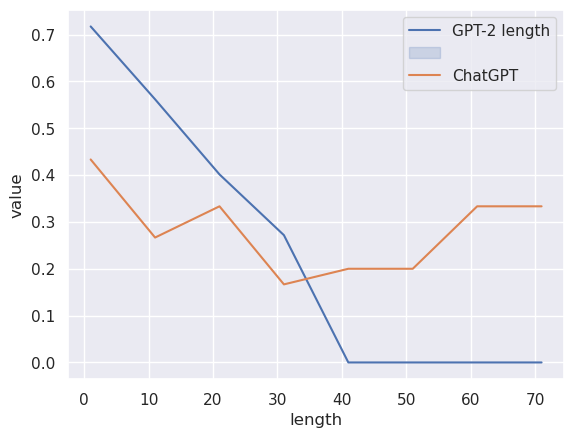

In [199]:
sns.lineplot(x='length', y='value', hue='variable', data=pd.melt(df_length_metrics[['length_exact', 'length_exact_chatgpt', 'length']], ['length']))
plt.legend(labels = ['GPT-2 length', None, 'ChatGPT'])
plt.show()

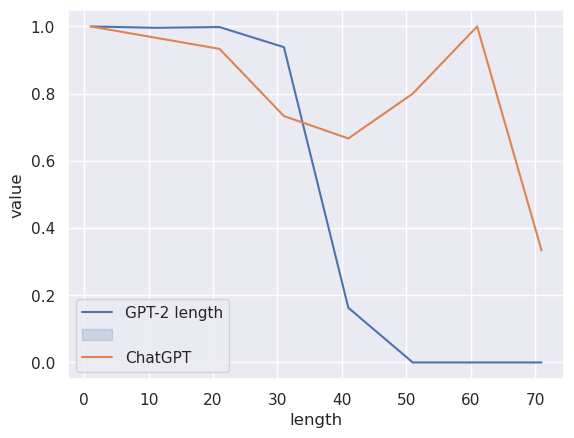

In [200]:
sns.lineplot(x='length', y='value', hue='variable', data=pd.melt(df_length_metrics[['length_appr', 'length_appr_chatgpt', 'length']], ['length']))
plt.legend(labels = ['GPT-2 length', None, 'ChatGPT'])
plt.show()

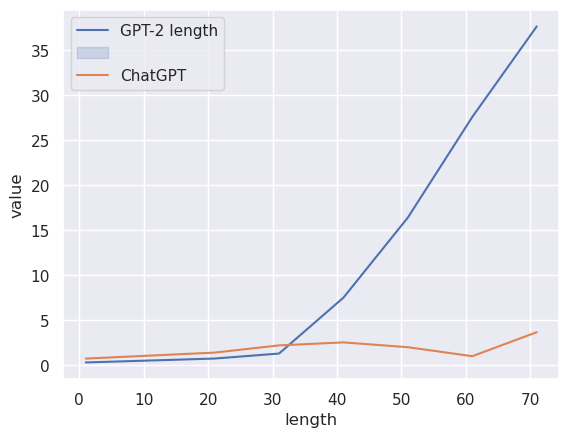

In [201]:
sns.lineplot(x='length', y='value', hue='variable', data=pd.melt(df_length_metrics[['length_mean_dev', 'length_mean_dev_chatgpt', 'length']], ['length']))
plt.legend(labels = ['GPT-2 length', None, 'ChatGPT'])
plt.show()

In [117]:
pos_exact(df_generation)

0.0

In [118]:
pos_unique_without_order(df_generation)

0.7611168831168833

In [119]:
pos_bigrams(df_generation)

0.4169665704665704

In [120]:
pos_trigrams(df_generation)

0.17833460742156393

In [121]:
pos_alignment(df_generation)

0.49176470588235294

In [264]:
df_generation[df_generation['sentiment'] == 2]

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check,lentense
667,You can also enable Harmony to train your Imam...,"[PRON, AUX, ADV, VERB, PROPN, PART, VERB, PRON...",2,future,"[PRON, AUX, ADV, VERB, PROPN, PART, VERB, PRON...",1,{future},1
668,But on the flight of the trade - off was a suc...,"[CCONJ, ADP, DET, NOUN, ADP, DET, NOUN, PUNCT,...",2,past,"[CCONJ, ADP, DET, NOUN, ADP, DET, NOUN, PUNCT,...",2,{past},1
669,When the Eastern States wins and then loses mo...,"[SCONJ, DET, PROPN, PROPN, VERB, CCONJ, ADV, V...",2,present,"[SCONJ, DET, PROPN, PROPN, VERB, CCONJ, ADV, V...",1,{present},1
670,At 8:30 a.m. the UFC Fight Night begins previe...,"[ADP, NUM, DET, PROPN, PROPN, PROPN, VERB, VER...",2,future,"[ADP, NUM, NOUN, DET, PROPN, PROPN, PROPN, VER...",1,{present},1
671,That 'd be slightly more fun .,"[PRON, AUX, PART, ADV, ADJ, NOUN, PUNCT]",2,future,"[PRON, AUX, AUX, ADV, ADJ, NOUN, PUNCT]",2,{future},1
...,...,...,...,...,...,...,...,...
995,"He ’s growing , out of growing to his max .","[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,present,"[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,{present},1
996,"And despite California ’s drought battling , m...","[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",2,past,"[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",1,{past},1
997,From the bench graphs above the reflected valu...,"[ADP, DET, NOUN, VERB, ADP, DET, VERB, NOUN, P...",2,present,"[ADP, DET, NOUN, NOUN, ADP, DET, VERB, NOUN, P...",2,{},0
998,Research on self - driving cars shows to the p...,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",2,present,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",1,{present},1


In [265]:
sentiment_exact(df_generation[df_generation['sentiment'] == 2])

0.47147147147147145

In [266]:
sentiment_approximate(df_generation[df_generation['sentiment'] == 2])

0.9459459459459459

In [273]:
df_generation[(df_generation['lentense'] > 0) & (df_generation['tense'] == 'future')]

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check,lentense
4,Based on this will hurt business lending insti...,"[VERB, ADP, PRON, AUX, VERB, NOUN, VERB, NOUN,...",0,future,"[VERB, ADP, PRON, AUX, VERB, NOUN, NOUN, NOUN,...",0,{future},1
5,You must hate that .,"[PRON, AUX, VERB, PRON, PUNCT]",0,future,"[PRON, AUX, VERB, PRON, PUNCT]",0,{future},1
6,They will refuse the plan to give up .,"[PRON, AUX, VERB, DET, NOUN, PART, VERB, ADP, ...",0,future,"[PRON, AUX, VERB, DET, NOUN, PART, VERB, ADP, ...",0,{future},1
8,You will now miss .,"[PRON, AUX, ADV, ADJ, PUNCT]",0,future,"[PRON, AUX, ADV, VERB, PUNCT]",1,{future},1
9,It ’s pretty boring .,"[PRON, VERB, ADV, ADJ, PUNCT]",0,future,"[PRON, VERB, ADV, ADJ, PUNCT]",0,{present},1
...,...,...,...,...,...,...,...,...
975,But I ca n’t wait to be a singing partner to “...,"[CCONJ, PRON, AUX, PROPN, VERB, PART, AUX, DET...",2,future,"[CCONJ, PRON, AUX, NOUN, VERB, PART, AUX, DET,...",2,{future},1
982,"For the first time and in the US , for revenue...","[ADP, DET, ADJ, NOUN, CCONJ, ADP, DET, PROPN, ...",2,future,"[ADP, DET, ADJ, NOUN, CCONJ, ADP, DET, PROPN, ...",1,{present},1
985,We are being funded right this way with whatev...,"[PRON, AUX, AUX, VERB, ADV, DET, NOUN, ADP, PR...",2,future,"[PRON, AUX, AUX, VERB, ADV, DET, NOUN, ADP, PR...",1,{future},1
986,"In his role , President Obama won the Democrat...","[ADP, PRON, NOUN, PUNCT, PROPN, PROPN, VERB, D...",2,future,"[ADP, PRON, NOUN, PUNCT, PROPN, PROPN, VERB, D...",2,{past},1


In [274]:
tense_exact(df_generation[(df_generation['lentense'] > 0) & (df_generation['tense'] == 'future')])

0.7914893617021277

# 2. Fluency metrics

In [122]:
perplexity = load("perplexity", module_type="metric")

In [123]:
def perpl(df):
    perplexities = perplexity.compute(predictions=df['text'].values.tolist(), model_id='gpt2', device='cpu')
    df['perplexity'] = perplexities['perplexities']
    return perplexities['mean_perplexity']

In [202]:
perpl(df_chatgpt)

Using pad_token, but it is not set yet.


  0%|          | 0/10 [00:00<?, ?it/s]

56.415898754172126

In [203]:
df_chatgpt

,text,length,perplexity
0,"The sun sets, painting the sky orange.",7,86.738991
1,"She smiled, her eyes sparkling.",5,42.686180
2,The waves crashed against the rocks as seagull...,10,38.942513
3,The moonlight danced upon the shimmering lake'...,8,72.072273
4,The autumn leaves whispered secrets in the bre...,7,272.168793
...,...,...,...
141,As the morning sun painted the sky in hues of ...,65,25.709038
142,"In the realm of imagination, where dreams take...",70,25.391672
143,"In the tapestry of life, we are all interconne...",73,17.450747
144,"In the vast expanse of the universe, our tiny ...",78,19.185068


<Axes: >

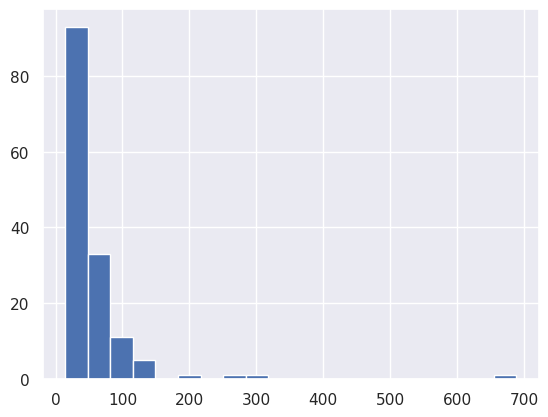

In [206]:
df_chatgpt[df_chatgpt['perplexity'] < 1000]['perplexity'].hist(bins = 20)

In [208]:
df_chatgpt[df_chatgpt['perplexity'] > 1000]

,text,length,perplexity


In [114]:
# df_mauve_compare = pd.read_csv('../230503_ucu_materials/data/val.csv')
# df_mauve_compare['pos'] = df_mauve_compare.apply(lambda row: eval(row['pos']), axis=1)
# df_mauve_compare

,text,words,pos,sentiment,tense
0,"X can use any attack , Poké - Power , or Poké ...",19,NOUN AUX VERB DET NOUN PUNCT PROPN PUNCT PROPN...,neutral,future
1,There were periods when everything was more op...,14,PRON VERB NOUN SCONJ PRON AUX ADV ADJ PUNCT CC...,neutral,past
2,Trans people are terrified of what lies ahead .,9,PROPN NOUN AUX VERB ADP PRON VERB ADV PUNCT,negative,present
3,Another Global horror is The Cube in Birmingha...,23,DET ADJ NOUN AUX DET PROPN ADP PROPN PUNCT DET...,negative,present
4,The innovative one piece stainless steel shiel...,26,DET ADJ NUM NOUN ADJ NOUN VERB NOUN ADP PROPN ...,positive,present
...,...,...,...,...,...
11027,The application of Dye Solar Cells ( DSC 's ) ...,38,DET NOUN ADP PROPN PROPN PROPN PUNCT PROPN PAR...,positive,present
11028,Along with the majority of Canadians elsewhere...,22,ADP ADP DET NOUN ADP PROPN ADV PUNCT PROPN VER...,neutral,past
11029,"IBM , like other established tech companies , ...",33,PROPN PUNCT ADP ADJ VERB NOUN NOUN PUNCT VERB ...,positive,past
11030,Valuation movements ( think potential falls ) ...,23,NOUN NOUN PUNCT VERB ADJ NOUN PUNCT AUX NOUN V...,neutral,future


In [36]:
# def compute_mauve(human_df, generated_df):
#     if len(generated_df) > 5000: num_buckets = 500
#     else: num_buckets = 'auto'
#     return mauve.compute_mauve(p_text=human_df['text'].values.tolist(), q_text=generated_df['text'].values.tolist(), device_id=0, max_text_length=256, verbose=True, num_buckets=num_buckets)

In [ ]:
# compute_mauve(df_mauve_compare, df_generation).mauve

Loading tokenizer
Tokenizing text...
Loading tokenizer
Loading model


# 3. Distinctivness metrics

In [130]:
def distinct_ngrams_in_sentence(df, n):
    distinct_ngrams = []
    for i in range(len(df)):
        ngrams = list(nltk.ngrams(df['text'][i].split(), n))
        unique_ngrams = set(ngrams)
        if len(ngrams) > 0: distinct_ngrams.append(len(unique_ngrams)/len(ngrams))
    return np.mean(distinct_ngrams)

In [219]:
distinct_ngrams_in_sentence(df_chatgpt, 1)

0.9131189900263962

In [220]:
distinct_ngrams_in_sentence(df_chatgpt, 2)

0.9990730231832536

In [221]:
distinct_ngrams_in_sentence(df_chatgpt, 3)

1.0

In [134]:
def distinct_ngrams_in_all_sentences(df, n):
    ngrams = []
    for i in range(len(df)):
        ngrams += list(nltk.ngrams(df['text'][i].split(), n))
    unique_ngrams = set(ngrams)
    return len(unique_ngrams)/len(ngrams)

In [222]:
distinct_ngrams_in_all_sentences(df_chatgpt, 1)

0.27859391395592864

In [223]:
distinct_ngrams_in_all_sentences(df_chatgpt, 2)

0.6197490452809602

In [224]:
distinct_ngrams_in_all_sentences(df_chatgpt, 3)

0.8173295454545455

In [138]:
def distinct_endings(df, n):
    sentence_endings = []
    for i in range(len(df)):
        sentence_endings.append(str(list(nltk.ngrams(df['text'][i].split(), 1))[-n:]))
    unique_endings = set(sentence_endings)
    return len(unique_endings)/len(sentence_endings)

In [225]:
distinct_endings(df_chatgpt, 2)

0.9383561643835616

In [226]:
distinct_endings(df_chatgpt, 3)

0.9657534246575342

In [141]:
def distinct_beginnings(df, n):
    sentence_beginnings = []
    for i in range(len(df)):
        sentence_beginnings.append(str(list(nltk.ngrams(df['text'][i].split(), 1))[:n]))
    unique_beginnings = set(sentence_beginnings)
    return len(unique_beginnings)/len(sentence_beginnings)

In [227]:
distinct_beginnings(df_chatgpt, 2)

0.3561643835616438

In [228]:
distinct_beginnings(df_chatgpt, 3)

0.5753424657534246

In [144]:
def distinct_ngrams_for_repeated_pos(df, n):
    ngrams_df = []
    i = 0
    while i < len(df):
        ngrams = []
        for j in range(5):
            ngrams += list(nltk.ngrams(df['text'][i + j].split(), n))
        unique_ngrams = set(ngrams)
        i += 5
        ngrams_df.append(len(unique_ngrams)/len(ngrams))
    return np.mean(ngrams_df)

In [145]:
distinct_ngrams_for_repeated_pos(df_generation, 2)

0.9919227818414462

In [146]:
distinct_ngrams_for_repeated_pos(df_generation, 3)

1.0

In [147]:
distinct_ngrams_for_repeated_pos(df_generation, 5)

1.0

In [148]:
def distinct_endings_for_repeated_pos(df, n):
    df_endings = []
    i = 0
    while i < len(df):
        sentence_endings = []
        for j in range(5):
            sentence_endings.append(str(list(nltk.ngrams(df['text'][i + j].split(), 1))[-n:]))
        unique_endings = set(sentence_endings)
        i += 5
        df_endings.append(len(unique_endings)/len(sentence_endings))
    return np.mean(df_endings)

In [149]:
distinct_endings_for_repeated_pos(df_generation, 2)

1.0

In [150]:
distinct_endings_for_repeated_pos(df_generation, 3)

1.0

In [151]:
def distinct_beginnings_for_repeated_pos(df, n):
    df_beginnings = []
    i = 0
    while i < len(df):
        sentence_beginnings = []
        for j in range(5):
            sentence_beginnings.append(str(list(nltk.ngrams(df['text'][i + j].split(), 1))[:n]))
        unique_beginnings = set(sentence_beginnings)
        i += 5
        df_beginnings.append(len(unique_beginnings)/len(sentence_beginnings))
    return np.mean(df_beginnings)

In [152]:
distinct_beginnings_for_repeated_pos(df_generation, 2)

1.0

In [153]:
distinct_beginnings_for_repeated_pos(df_generation, 3)

1.0

# 4. Repetition metrics

In [31]:
def distinct_ngrams_repetition(df, df_train, n):
    ngrams = []
    for i in range(len(df)):
        ngrams += list(nltk.ngrams(df['text'][i].split(), n))
    ngrams_train = []
    for i in range(len(df_train)):
        ngrams_train += list(nltk.ngrams(df_train['text'][i].split(), n))
    ngrams_rep = [x for x in ngrams if x in ngrams_train]
    return 1-len(ngrams_rep)/len(ngrams)

In [32]:
distinct_ngrams_repetition(df_generation, df_train, 3)

0.5627926120286053

In [33]:
distinct_ngrams_repetition(df_generation, df_train, 5)

0.962665596146126